In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
# from scipy import interpolate
# import time
%matplotlib inline  
# import sys
# sys.path.append('/gpfs2/projects/project-bus_capstone_2016/workspace/jz2308/bus-Capstone')

os.chdir('..')
import gtfs # homemade module
import ttools
os.chdir('/gpfs2/projects/project-bus_capstone_2016/workspace/share')

## 1. Get data

In [2]:
# get all the schedule data. (subset can be created later)
# trips = gtfs.load_trips('2015-12-03','gtfs/')
# stops = gtfs.load_stops('2015-12-03','gtfs/')
stop_times, tz_sched = gtfs.load_stop_times('2015-12-03','gtfs/')
# tcal=gtfs.TransitCalendar('2015-12-03')
# thurs_services = tcal.get_service_ids('2015-12-03')
# thurs_trips = trips.service_id.isin(thurs_services)
# thurs_stops = stop_times.reset_index().set_index('trip_id').loc[thurs_trips]
interpolated = pd.read_csv('2015-12-03_interpolated.csv')
print 'Finished loading interpolated stop time and schedule data.'

Finished loading interpolated stop time and schedule data.


In [3]:
interpolated.head()

,route,trip_id,trip_date,vehicle_id,stop_id,interpolated_arrival_time
0,MTA NYCT_M101,OH_D5-Weekday-SDon-036500_M101_38,2015-12-03,MTA NYCT_5879,402805,0 days 06:10:56.778916
1,MTA NYCT_M101,OH_D5-Weekday-SDon-036500_M101_38,2015-12-03,MTA NYCT_5879,405057,0 days 06:14:24.977703
2,MTA NYCT_M101,OH_D5-Weekday-SDon-036500_M101_38,2015-12-03,MTA NYCT_5879,403416,0 days 06:16:58.526210
3,MTA NYCT_M101,OH_D5-Weekday-SDon-036500_M101_38,2015-12-03,MTA NYCT_5879,402809,0 days 06:17:25.226045
4,MTA NYCT_M101,OH_D5-Weekday-SDon-036500_M101_38,2015-12-03,MTA NYCT_5879,402811,0 days 06:18:36.819142


#### Join schedule times from each stop and convert times to numeric

In [4]:
interpolated = interpolated.merge(stop_times[['arrival_time','stop_sequence']],how='left',left_on=['trip_id','stop_id'],right_index=True)

In [5]:
interpolated['interpolated_arrival_time'] = pd.to_timedelta(interpolated['interpolated_arrival_time'])
interpolated['schedule_convert'] = pd.to_timedelta(interpolated['arrival_time'])
interpolated.set_index(['route','trip_id','trip_date','vehicle_id','stop_sequence','stop_id'],inplace=True)

## 2. Group the estimates by route and trip, and for each route identify the stop with the most estimates

In [6]:
trip_groups = interpolated.groupby(level=(0,2,5,4)).size()

In [7]:
def series_max(s):
    return s.idxmax()[2]
densest_stops = trip_groups.groupby(level=(0)).apply(series_max)
densest_stops

route
MTA NYCT_B1      300009
MTA NYCT_B11     301173
MTA NYCT_B12     301328
MTA NYCT_B13     301505
MTA NYCT_B14     301598
MTA NYCT_B15     301135
MTA NYCT_B16     301677
MTA NYCT_B17     300853
MTA NYCT_B2      300173
MTA NYCT_B20     301959
MTA NYCT_B24     503993
MTA NYCT_B25     302383
MTA NYCT_B26     302372
MTA NYCT_B3      300261
MTA NYCT_B31     300175
MTA NYCT_B32     302304
MTA NYCT_B35     302692
MTA NYCT_B36     300019
MTA NYCT_B37     302914
MTA NYCT_B38     302948
MTA NYCT_B39     403679
MTA NYCT_B4      300368
MTA NYCT_B41     303295
MTA NYCT_B42     303358
MTA NYCT_B43     303711
MTA NYCT_B44     303483
MTA NYCT_B44+    303441
MTA NYCT_B45     303531
MTA NYCT_B46     303592
MTA NYCT_B47     300857
                  ...  
MTABC_Q50        101743
MTABC_Q52        550070
MTABC_Q53        550070
MTABC_Q60        504399
MTABC_Q64        551812
MTABC_Q65        550032
MTABC_Q66        551894
MTABC_Q67        503832
MTABC_Q69        550010
MTABC_Q70        504542
MTABC_Q72 

## 3. Define Wait Assessment calculation and apply

In [8]:
def peak_hour(x):
    if x > '06:00:00' and x < '09:00:00':
        return True
    else:
        if x > '16:00:00' and x < '19:00:00':
            return True
        else:
            return False

In [9]:
def wait_ass(x,y):
    if x == True:
        if y >= 3*60:
            return True
        else:
            return False
    if x == False:
        if y>= 5*60:
            return True
        else:
            return False         

In [10]:
def wa_at_stop(route,stop):
    pd.options.mode.chained_assignment = None
    interpolated_2 = interpolated.xs((route,stop),level=(0,5),drop_level=False)
    interpolated_2.reset_index(inplace=True)
    interpolated_2['sche_headway'] = interpolated_2.sort(columns='schedule_convert')['schedule_convert'].diff()
    interpolated_2['inter_headway'] = interpolated_2.sort(columns='interpolated_arrival_time')['interpolated_arrival_time'].diff()
    interpolated_2['sche_h_sec'] = interpolated_2['sche_headway']/ttools.datetime.timedelta(seconds=1)
    interpolated_2['inter_h_sec'] = interpolated_2['inter_headway']/ttools.datetime.timedelta(seconds=1)
    interpolated_2['P_hour'] = map(lambda x:peak_hour(x),interpolated_2['arrival_time'])
    interpolated_2['diff'] = interpolated_2['inter_h_sec'] - interpolated_2['sche_h_sec']
    interpolated_2['wait_ass'] = map(lambda x,y:wait_ass(x,y), interpolated_2['P_hour'],interpolated_2['diff'])
    ##wait assessment for the single route on the single stop
    # 100% is best
    return 1.0-(1.0*interpolated_2['wait_ass'].sum()/len(interpolated_2['wait_ass']))

Demonstrate example

In [11]:
wa_at_stop('MTA NYCT_B1',300009)

0.8957055214723927

Show the mean Wait Assessment if taking only the "densest stop" for each route

In [12]:
all_routes = pd.Series(index=densest_stops.index)
for i,v in densest_stops.iteritems():
    all_routes[i] = wa_at_stop(i,v)

In [13]:
all_routes.mean()

0.79945940207255217

Calculate Wait Assessment for ALL stops with more than 50 estimates and assemble results into a DataFrame

In [12]:
all_stops = pd.Series(index=trip_groups.index)
for i, v in trip_groups.iteritems():
    if v > 50:
        all_stops[i] = wa_at_stop(i[0],i[2])
all_stops_df = pd.DataFrame.from_dict(all_stops).dropna().reset_index().rename(columns={0:'wa'})

In [15]:
# export results
all_stops_df.to_csv('all_stops_wa.csv')

### 3a. Test significance of stop sequence
The hypothesis is: later stops along a trip will have worse performance metrics, such as Wait Assessment (lower is worse) or Mean Headway Deviation (higher is worse).

In [16]:
all_stops_df.corr()

,stop_id,stop_sequence,wa
stop_id,1.000000,-0.014718,-0.090302
stop_sequence,-0.014718,1.000000,-0.538366
wa,-0.090302,-0.538366,1.000000


In [13]:
all_stops_df.head(25)

,route,trip_date,stop_id,stop_sequence,wa
0,MTA NYCT_B1,2015-12-03,300002,2,0.860140
1,MTA NYCT_B1,2015-12-03,300003,3,0.883212
2,MTA NYCT_B1,2015-12-03,300004,4,0.891304
3,MTA NYCT_B1,2015-12-03,300006,5,0.928058
4,MTA NYCT_B1,2015-12-03,300007,6,0.915033
5,MTA NYCT_B1,2015-12-03,300008,7,0.910828
6,MTA NYCT_B1,2015-12-03,300009,8,0.895706
7,MTA NYCT_B1,2015-12-03,300010,9,0.893333
8,MTA NYCT_B1,2015-12-03,300011,10,0.889571
9,MTA NYCT_B1,2015-12-03,300012,11,0.875776


In [23]:
all_stops_df_indexed = all_stops_df.set_index(['route','stop_sequence'])
all_stops_df_indexed.sort_index(inplace=True)

In [25]:
b1 = all_stops_df_indexed.groupby(level=(0,1))['wa'].mean().loc['MTA NYCT_B1']

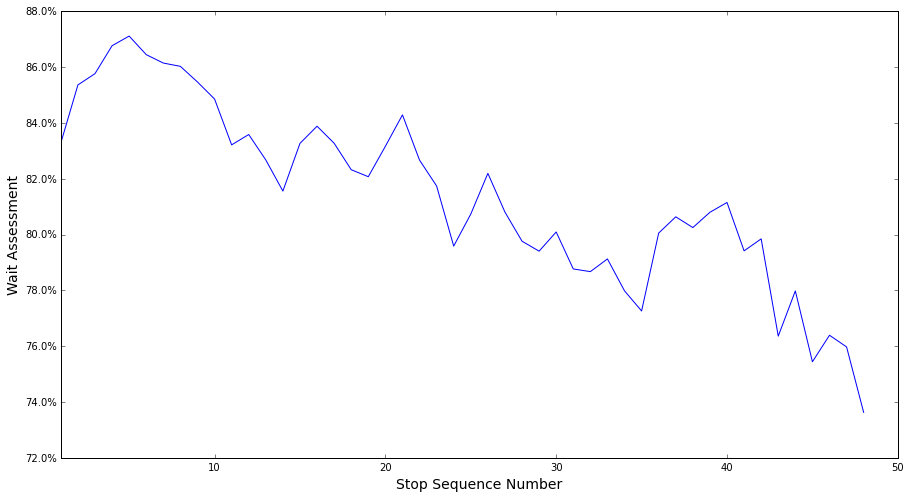

In [31]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.plot(b1, 'k-',color='blue')
plt.ylabel('Wait Assessment', fontsize=14)
plt.xlabel('Stop Sequence Number', fontsize=14)
plt.xlim(1,50)
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.1f}%'.format(x*100) for x in vals])
plt.savefig('/gpfs2/projects/project-bus_capstone_2016/workspace//mu529/Bus-Capstone/plots/wa_by_stop_sequence.png')
plt.show()

In [32]:
import statsmodels.formula.api as smf
results = smf.ols('wa ~ stop_sequence', data=all_stops_df.dropna().reset_index()).fit()
print results.summary()

                            OLS Regression Results                            
Dep. Variable:                     wa   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     6701.
Date:                Fri, 22 Jul 2016   Prob (F-statistic):               0.00
Time:                        14:27:46   Log-Likelihood:                 25037.
No. Observations:               16421   AIC:                        -5.007e+04
Df Residuals:                   16419   BIC:                        -5.005e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept         0.8405      0.001   1141.083

In [40]:
f1=open('/gpfs2/projects/project-bus_capstone_2016/workspace//mu529/Bus-Capstone/plots/ols_summary.txt', 'w+')
f1.write(str(results.summary()))
f1.close()

## Bunching Rate

In [56]:
def bunched(x):
    try:
        if pd.to_timedelta(x)<ttools.datetime.timedelta(minutes=1):
            return True
        else:
            return False
    except:
        return False

In [105]:
bunch_bool = interpolated.loc['MTA NYCT_B41'].groupby(level=(0,1,2))['interpolated_arrival_time'].diff().apply(bunched)
x = list(bunch_bool.groupby(level=3).mean().index)
y = list(bunch_bool.groupby(level=3).mean().values)
bunch_bool2 = interpolated.loc['MTA NYCT_B63'].groupby(level=(0,1,2))['interpolated_arrival_time'].diff().apply(bunched)
x2 = list(bunch_bool2.groupby(level=3).mean().index)
y2 = list(bunch_bool2.groupby(level=3).mean().values)
bunch_bool3 = interpolated.loc['MTA NYCT_B61'].groupby(level=(0,1,2))['interpolated_arrival_time'].diff().apply(bunched)
x3 = list(bunch_bool3.groupby(level=3).mean().index)
y3 = list(bunch_bool3.groupby(level=3).mean().values)

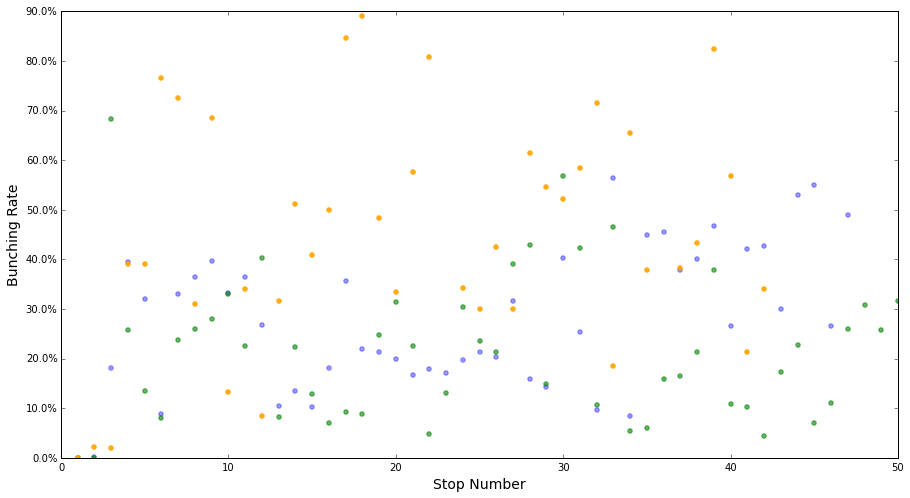

In [106]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.scatter(x,y, color='b',alpha=0.4)
ax.scatter(x2,y2, color='green',alpha=0.6)
ax.scatter(x3,y3, color='orange',alpha=0.9)
plt.ylabel('Bunching Rate', fontsize=14)
plt.xlabel('Stop Number', fontsize=14)
plt.xlim(0,50)
plt.ylim(0.0,0.9)
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.1f}%'.format(x*100) for x in vals])
plt.savefig('/gpfs2/projects/project-bus_capstone_2016/workspace//mu529/Bus-Capstone/plots/bunching_rates.png')
plt.show()

## 4. Define Mean Headway Deviation and apply

In [18]:
def mean_hw_dev_at_stop(route,stop):
    pd.options.mode.chained_assignment = None
    interpolated_2 = interpolated.xs((route,stop),level=(0,5),drop_level=False)
    interpolated_2.reset_index(inplace=True)
    interpolated_2['sche_headway'] = interpolated_2.sort(columns='schedule_convert')['schedule_convert'].diff()
    interpolated_2['inter_headway'] = interpolated_2.sort(columns='interpolated_arrival_time')['interpolated_arrival_time'].diff()
    interpolated_2['sche_h_sec'] = interpolated_2['sche_headway']/ttools.datetime.timedelta(seconds=1)
    interpolated_2['inter_h_sec'] = interpolated_2['inter_headway']/ttools.datetime.timedelta(seconds=1)
    # interpolated_2['P_hour'] = map(lambda x:peak_hour(x),interpolated_2['arrival_time'])
    interpolated_2['abs_diff'] = abs(interpolated_2['inter_h_sec'] - interpolated_2['sche_h_sec'])
    # interpolated_2['wait_ass'] = map(lambda x,y:wait_ass(x,y), interpolated_2['P_hour'],interpolated_2['diff'])
    ##wait assessment for the single route on the single stop
    # 100% is best
    return interpolated_2['abs_diff'].dropna().mean()

Show an example

In [19]:
mean_hw_dev_at_stop('MTA NYCT_B1',300009)

136.72597633950616

In [20]:
all_routes_hwdev = pd.Series(index=densest_stops.index)
for i,v in densest_stops.iteritems():
    all_routes_hwdev[i] = mean_hw_dev_at_stop(i,v)

Calculate Mean Headway Deviation for ALL stops with more than 50 estimates and assemble results into a DataFrame

In [103]:
all_stops_hwdev = pd.Series(index=trip_groups.index)
for i, v in trip_groups.iteritems():
    if v > 50:
        all_stops_hwdev[i] = mean_hw_dev_at_stop(i[0],i[2])
all_stops_hwdev_df = pd.DataFrame.from_dict(all_stops_hwdev).dropna().reset_index().rename(columns={0:'mean_hwdev'})

### 4a. Test significance of stop sequence

In [104]:
results = smf.ols('mean_hwdev ~ stop_sequence', data=all_stops_hwdev_df.dropna().reset_index()).fit()
print results.summary()

                            OLS Regression Results                            
Dep. Variable:             mean_hwdev   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     5383.
Date:                Mon, 18 Jul 2016   Prob (F-statistic):               0.00
Time:                        11:32:20   Log-Likelihood:                -97228.
No. Observations:               16421   AIC:                         1.945e+05
Df Residuals:                   16419   BIC:                         1.945e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept       231.7930      1.261    183.775